In [2]:
# import required package for data handling
import pandas as pd
import numpy as np

# import required packages for splitting data
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import required packages for evaluating models
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# import `logistic regression` model
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import zscore, skew
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import chain
import xgboost
from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)

In [3]:
feat_mat = pd.read_csv('feat_mat.csv', header=0).drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])
tar = pd.read_csv('target_df.csv')

In [4]:
y2 = tar.Y2

In [5]:
high_corr_map = {'C7_imputed_iqr_standardized_normalized': ['sales_per_share_iqr_standardized_normalized'],
 'words_per_sentence_iqr_standardized_normalized': ['short_sentences_per_iqr_standardized_normalized',
  'long_sentences_per_iqr_standardized_normalized'],
 'real_word_per_iqr_standardized_normalized': ['non_real_word_per_iqr_standardized_normalized'],
 'non_real_word_per_iqr_standardized_normalized': ['real_word_per_iqr_standardized_normalized'],
 'short_sentences_per_iqr_standardized_normalized': ['words_per_sentence_iqr_standardized_normalized',
  'long_sentences_per_iqr_standardized_normalized'],
 'long_sentences_per_iqr_standardized_normalized': ['words_per_sentence_iqr_standardized_normalized',
  'short_sentences_per_iqr_standardized_normalized'],
 'neg_words_percent_iqr_standardized_normalized': ['uncertain_words_percent_iqr_standardized_normalized'],
 'uncertain_words_percent_iqr_standardized_normalized': ['neg_words_percent_iqr_standardized_normalized'],
 'sales_per_share_iqr_standardized_normalized': ['C7_imputed_iqr_standardized_normalized'],
 'outstanding_share_per_iqr_standardized_normalized': ['offering_share_per_iqr_standardized_normalized',
  'C5_prime_iqr_standardized_normalized'],
 'offering_share_per_iqr_standardized_normalized': ['outstanding_share_per_iqr_standardized_normalized',
  'C5_prime_iqr_standardized_normalized'],
 'C5_prime_iqr_standardized_normalized': ['outstanding_share_per_iqr_standardized_normalized',
  'offering_share_per_iqr_standardized_normalized']}

In [6]:
high_corr_map_alt = {'C7_imputed_normalized_alt': ['sales_per_share_normalized_alt'],
 'words_per_sentence_normalized_alt': ['short_sentences_per_normalized_alt',
  'long_sentences_per_normalized_alt'],
 'real_word_per_normalized_alt': ['non_real_word_per_normalized_alt'],
 'non_real_word_per_normalized_alt': ['real_word_per_normalized_alt'],
 'short_sentences_per_normalized_alt': ['words_per_sentence_normalized_alt',
  'long_sentences_per_normalized_alt'],
 'long_sentences_per_normalized_alt': ['words_per_sentence_normalized_alt',
  'short_sentences_per_normalized_alt'],
 'neg_words_percent_normalized_alt': ['uncertain_words_percent_normalized_alt'],
 'uncertain_words_percent_normalized_alt': ['neg_words_percent_normalized_alt'],
 'sales_per_share_normalized_alt': ['C7_imputed_normalized_alt'],
 'outstanding_share_per_normalized_alt': ['offering_share_per_normalized_alt',
  'C5_prime_normalized_alt'],
 'offering_share_per_normalized_alt': ['outstanding_share_per_normalized_alt',
  'C5_prime_normalized_alt'],
 'C5_prime_normalized_alt': ['outstanding_share_per_normalized_alt',
  'offering_share_per_normalized_alt']}

In [7]:
def get_important_features_rfe(xTrain, yTrain, num_feats):
    '''
    Takes training values and returns the most important features in order
    '''
    clf = LogisticRegression(random_state=123, max_iter = 1000)
    selector = RFE(clf, num_feats, step=1)
    selector.fit(xTrain, yTrain)
    
    return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    
    
feat_rfe = get_important_features_rfe(feat_mat[[i for i in list(feat_mat.columns) 
                                     if i != 'I1' and 
                                                (('iqr_standardized_normalized' in i) or 
                                                 ('normalized_alt' in i))]],
                          y2, 10)

In [8]:
feat_rfe[:10]

['C3_imputed_normalized_alt',
 'C4_iqr_standardized_normalized',
 'C4_normalized_alt',
 'C5_prime_normalized_alt',
 'C6_prime_iqr_standardized_normalized',
 'neg_words_percent_normalized_alt',
 'offering_share_per_iqr_standardized_normalized',
 'outstanding_share_per_normalized_alt',
 'short_sentences_per_iqr_standardized_normalized',
 'short_sentences_per_normalized_alt']

In [9]:
predictors_y2 = feat_mat[feat_rfe[:10]]

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    #Model building
    clf1 = LogisticRegression()

    
    # Splitting data into testing and training
    X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)
    
    # Begin oversampling
    oversample = pd.concat([X2_train,y2_train],axis=1)
    max_size = oversample['Y2'].value_counts().max()
    lst = [oversample]
    for class_index, group in oversample.groupby('Y2'):
        lst.append(group.sample(max_size-len(group), replace=True))
    X2_train = pd.concat(lst)
    y2_train=pd.DataFrame.copy(X2_train['Y2'])
    del X2_train['Y2']
    
    # fitting model on oversampled data
    clf1.fit(X2_train, y2_train)
    
    y2_pred = clf1.predict(X2_test)
    
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)
    
    #calculate f1-score and AUC
    
    clf1_roc_auc = roc_auc_score(y2_test, y2_pred)
    
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
    auc_lst.append(clf1_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

print('Confusion Matrix for Classfier:')
print(confusion_matrix_y2)

print('Classification Report for Classfier:')
print(classification_report(y2_test, y2_pred))

imp = pd.DataFrame(zip(predictors_y2.columns, clf1.coef_[0]))
imp.columns = ['field','importance']
imp.sort_values('importance', inplace = True)
imp


/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6701; AUC 0.6212 
Accuracy of classifier on test set: 0.636
10-fold cross validation average accuracy of clf1: 0.604
Confusion Matrix for Classfier:
[[18 15]
 [33 66]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.35      0.55      0.43        33
           1       0.81      0.67      0.73        99

    accuracy                           0.64       132
   macro avg       0.58      0.61      0.58       132
weighted avg       0.70      0.64      0.66       132



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


,field,importance
2,C4_normalized_alt,-1.287942
0,C3_imputed_normalized_alt,-0.306260
5,neg_words_percent_normalized_alt,-0.147031
9,short_sentences_per_normalized_alt,-0.112678
7,outstanding_share_per_normalized_alt,0.152084
8,short_sentences_per_iqr_standardized_normalized,0.153150
4,C6_prime_iqr_standardized_normalized,0.525858
6,offering_share_per_iqr_standardized_normalized,0.582705
3,C5_prime_normalized_alt,0.598360
1,C4_iqr_standardized_normalized,1.485722


In [10]:
imp

,field,importance
2,C4_normalized_alt,-1.287942
0,C3_imputed_normalized_alt,-0.306260
5,neg_words_percent_normalized_alt,-0.147031
9,short_sentences_per_normalized_alt,-0.112678
7,outstanding_share_per_normalized_alt,0.152084
8,short_sentences_per_iqr_standardized_normalized,0.153150
4,C6_prime_iqr_standardized_normalized,0.525858
6,offering_share_per_iqr_standardized_normalized,0.582705
3,C5_prime_normalized_alt,0.598360
1,C4_iqr_standardized_normalized,1.485722


In [11]:
for i in high_corr_map:
    if i in imp.field.values:
        map_flds = [j for j in high_corr_map[i] if j in imp.field.values]
        if len(map_flds) > 0:
            print(i, map_flds)

In [12]:
for i in high_corr_map_alt:
    if i in imp.field.values:
        map_flds = [j for j in high_corr_map_alt[i] if j in imp.field.values]
        if len(map_flds) > 0:
            print(i, map_flds)

outstanding_share_per_normalized_alt ['C5_prime_normalized_alt']
C5_prime_normalized_alt ['outstanding_share_per_normalized_alt']


In [13]:
predictors_y2 = feat_mat[[i for i in feat_rfe[:16] 
                          if i not in ['short_sentences_per_normalized_alt','outstanding_share_per_normalized_alt',
                                      'short_sentences_per_iqr_standardized_normalized',
                                       'long_sentences_per_iqr_standardized_normalized',
                                      'neg_words_percent_iqr_standardized_normalized',
                                      'C4_normalized_alt','outstanding_share_per_iqr_standardized_normalized',
                                      'uncertain_words_percent_normalized_alt']]]

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    #Model building
    clf1 = LogisticRegression()

    
    # Splitting data into testing and training
    X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)
    
    # Begin oversampling
    oversample = pd.concat([X2_train,y2_train],axis=1)
    max_size = oversample['Y2'].value_counts().max()
    lst = [oversample]
    for class_index, group in oversample.groupby('Y2'):
        lst.append(group.sample(max_size-len(group), replace=True))
    X2_train = pd.concat(lst)
    y2_train=pd.DataFrame.copy(X2_train['Y2'])
    del X2_train['Y2']
    
    # fitting model on oversampled data
    clf1.fit(X2_train, y2_train)
    
    y2_pred = clf1.predict(X2_test)
    
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)
    
    #calculate f1-score and AUC
    
    clf1_roc_auc = roc_auc_score(y2_test, y2_pred)
    
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
    auc_lst.append(clf1_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

print('Confusion Matrix for Classfier:')
print(confusion_matrix_y2)

print('Classification Report for Classfier:')
print(classification_report(y2_test, y2_pred))

imp = pd.DataFrame(zip(predictors_y2.columns, clf1.coef_[0]))



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6692; AUC 0.6094 
Accuracy of classifier on test set: 0.644
10-fold cross validation average accuracy of clf1: 0.598
Confusion Matrix for Classfier:
[[18 15]
 [32 67]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.36      0.55      0.43        33
           1       0.82      0.68      0.74        99

    accuracy                           0.64       132
   macro avg       0.59      0.61      0.59       132
weighted avg       0.70      0.64      0.66       132



In [14]:
imp.columns = ['field', 'imp']
imp.sort_values(by = 'imp')
imp.sort_values('imp')

,field,imp
0,C3_imputed_normalized_alt,-0.406219
7,words_per_sentence_iqr_standardized_normalized,-0.287696
4,neg_words_percent_normalized_alt,-0.116932
1,C4_iqr_standardized_normalized,0.182342
6,words_per_sentence_normalized_alt,0.360963
5,offering_share_per_iqr_standardized_normalized,0.416194
3,C6_prime_iqr_standardized_normalized,0.572325
2,C5_prime_normalized_alt,0.597271


In [15]:
for i in high_corr_map:
    if i in imp.field.values:
        map_flds = [j for j in high_corr_map[i] if j in imp.field.values]
        if len(map_flds) > 0:
            print(i, map_flds)

In [16]:
for i in high_corr_map_alt:
    if i in imp.field.values:
        map_flds = [j for j in high_corr_map_alt[i] if j in imp.field.values]
        if len(map_flds) > 0:
            print(i, map_flds)

### PCA

In [17]:
feat_mat.columns[-6:]

Index(['C2', 'data_updated', 'C3_prime', 'industry_bin__Manufacturing',
       'industry_bin__Other', 'industry_bin__Services'],
      dtype='object')

In [18]:
pca = PCA(0.95)
# pca_transformed = pca.fit_transform(feat_mat[[i for i in feat_rfe[:10]]])

pca_transformed = pca.fit_transform(feat_mat[[i for i in feat_rfe[:11] if 'alt' in i or i in feat_mat.columns[-6:]]])

In [19]:
predictors_y2 = pca_transformed

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    #Model building
    clf1 = LogisticRegression()

    
    # Splitting data into testing and training
    X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)
    X2_train = pd.DataFrame(X2_train)
    X2_train['Y2'] = y2_train.values
    # Begin oversampling
    oversample = X2_train
    max_size = oversample['Y2'].value_counts().max()
    lst = [oversample]
    for class_index, group in oversample.groupby('Y2'):
        lst.append(group.sample(max_size-len(group), replace=True))
    X2_train = pd.concat(lst)
    y2_train=pd.DataFrame.copy(X2_train['Y2'])
    del X2_train['Y2']
    
    # fitting model on oversampled data
    clf1.fit(pd.DataFrame(X2_train), y2_train)
    
    y2_pred = clf1.predict(X2_test)
    
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)
    
    #calculate f1-score and AUC
    
    clf1_roc_auc = roc_auc_score(y2_test, y2_pred)
    
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
    auc_lst.append(clf1_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

print('Confusion Matrix for Classfier:')
print(confusion_matrix_y2)

print('Classification Report for Classfier:')
print(classification_report(y2_test, y2_pred))


/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.5963; AUC 0.5527 
Accuracy of classifier on test set: 0.545
10-fold cross validation average accuracy of clf1: 0.492
Confusion Matrix for Classfier:
[[16 17]
 [43 56]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.27      0.48      0.35        33
           1       0.77      0.57      0.65        99

    accuracy                           0.55       132
   macro avg       0.52      0.53      0.50       132
weighted avg       0.64      0.55      0.58       132



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


No immediate clear impact here

Alt approach:
- RFE on each set
- See which one has best representation of each variable
- same with cat vars

Index(['C2', 'data_updated', 'C3_prime', 'industry_bin__Manufacturing',
       'industry_bin__Other', 'industry_bin__Services'],
      dtype='object')

In [69]:
# def get_important_features_rfe_alt(xTrain, yTrain, num_feats):
#     '''
#     Takes training values and returns the most important features in order
#     '''
#     clf = LogisticRegression(random_state=123, max_iter = 1000)
#     selector = RFE(clf, num_feats, step=1)
#     selector.fit(xTrain, yTrain)
    
#     return [x for _,x in sorted(zip(selector.ranking_, list(xTrain.columns)))]
    


In [20]:
clf = LogisticRegression(random_state=123, max_iter = 1000)
selector = RFE(clf, 3, step=1)
selector.fit(feat_mat[feat_mat.columns[-6:]],y2)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=1000,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=123, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=3, step=1, verbose=0)

In [21]:
selector.ranking_

array([1, 2, 4, 3, 1, 1])

In [22]:
feat_mat.columns[-6:]

Index(['C2', 'data_updated', 'C3_prime', 'industry_bin__Manufacturing',
       'industry_bin__Other', 'industry_bin__Services'],
      dtype='object')

In [23]:
cat_feat_rfe = get_important_features_rfe(feat_mat[feat_mat.columns[-6:]],
                          y2, 1)
cat_feat_rfe

['industry_bin__Other',
 'C2',
 'industry_bin__Services',
 'data_updated',
 'industry_bin__Manufacturing',
 'C3_prime']

In [24]:
orig_cont_feat_rfe = get_important_features_rfe(feat_mat[[i for i in feat_mat.columns if 'iqr_standardized_normalized' in i]],
                          y2, 5)
orig_cont_feat_rfe

['C4_iqr_standardized_normalized',
 'C5_prime_iqr_standardized_normalized',
 'C6_prime_iqr_standardized_normalized',
 'offering_share_per_iqr_standardized_normalized',
 'uncertain_words_percent_iqr_standardized_normalized',
 'outstanding_share_per_iqr_standardized_normalized',
 'short_sentences_iqr_standardized_normalized',
 'real_word_per_iqr_standardized_normalized',
 'non_real_word_per_iqr_standardized_normalized',
 'pos_words_percent_iqr_standardized_normalized',
 'neg_words_percent_iqr_standardized_normalized',
 'sales_per_share_iqr_standardized_normalized',
 'short_sentences_per_iqr_standardized_normalized',
 'words_per_sentence_iqr_standardized_normalized',
 'C7_imputed_iqr_standardized_normalized',
 'total_shares_iqr_standardized_normalized',
 'long_words_per_iqr_standardized_normalized',
 'long_sentences_per_iqr_standardized_normalized',
 'C3_imputed_iqr_standardized_normalized',
 'C1_iqr_standardized_normalized']

In [25]:
alt_cont_feat_rfe = get_important_features_rfe(feat_mat[[i for i in feat_mat.columns if 'alt' in i]],
                          y2, 5)
alt_cont_feat_rfe

['C3_imputed_normalized_alt',
 'C5_prime_normalized_alt',
 'C6_prime_normalized_alt',
 'outstanding_share_per_normalized_alt',
 'uncertain_words_percent_normalized_alt',
 'offering_share_per_normalized_alt',
 'C4_normalized_alt',
 'short_sentences_per_normalized_alt',
 'long_sentences_per_normalized_alt',
 'pos_words_percent_normalized_alt',
 'neg_words_percent_normalized_alt',
 'short_sentences_normalized_alt',
 'words_per_sentence_normalized_alt',
 'sales_per_share_normalized_alt',
 'C7_imputed_normalized_alt',
 'real_word_per_normalized_alt',
 'non_real_word_per_normalized_alt',
 'long_words_per_normalized_alt',
 'C1_normalized_alt',
 'total_shares_normalized_alt']

In [26]:
initial_feat_list = [i for i in (cat_feat_rfe[:3] + orig_cont_feat_rfe[:5] + alt_cont_feat_rfe[:5]) if 
                     i not in ['C6_prime_iqr_standardized_normalized','C5_prime_iqr_standardized_normalized']]

In [27]:
initial_feat_list

['industry_bin__Other',
 'C2',
 'industry_bin__Services',
 'C4_iqr_standardized_normalized',
 'offering_share_per_iqr_standardized_normalized',
 'uncertain_words_percent_iqr_standardized_normalized',
 'C3_imputed_normalized_alt',
 'C5_prime_normalized_alt',
 'C6_prime_normalized_alt',
 'outstanding_share_per_normalized_alt',
 'uncertain_words_percent_normalized_alt']

In [28]:
alt_feat_lst = get_important_features_rfe(feat_mat[[i for i in feat_mat.columns if 'I1' not in i 
                                                    and i not in ['C4_normalized_alt', 'C4','outstanding_share_per_normalized_alt',
                                                                 'short_sentences', 'C4_normalized',
                                                                  'outstanding_share_per_normalized',
                                                                  'offering_share_per_normalized_alt',
                                                                 'offering_share_per_normalized',
                                                                 'C5_prime_normalized_alt',
                                                                 'C5_prime_normalized',
                                                                 'C5_prime',
                                                                 'offering_share_per',
                                                                 'outstanding_share_per']]],
                          y2, 10)

In [29]:
alt_feat_lst[:10]

['C2',
 'C3_imputed_normalized',
 'C5_prime_iqr_standardized_normalized',
 'C6_prime_iqr_standardized_normalized',
 'C7_imputed',
 'industry_bin__Other',
 'offering_share_per_iqr_standardized_normalized',
 'outstanding_share_per_iqr_standardized_normalized',
 'short_sentences_iqr_standardized',
 'total_shares_iqr_standardized']

In [30]:
predictors_y2 = feat_mat[alt_feat_lst[:10]]

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    #Model building
    clf1 = LogisticRegression()

    
    # Splitting data into testing and training
    X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)
    
    # Begin oversampling
    oversample = pd.concat([X2_train,y2_train],axis=1)
    max_size = oversample['Y2'].value_counts().max()
    lst = [oversample]
    for class_index, group in oversample.groupby('Y2'):
        lst.append(group.sample(max_size-len(group), replace=True))
    X2_train = pd.concat(lst)
    y2_train=pd.DataFrame.copy(X2_train['Y2'])
    del X2_train['Y2']
    
    # fitting model on oversampled data
    clf1.fit(X2_train, y2_train)
    
    y2_pred = clf1.predict(X2_test)
    
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)
    
    #calculate f1-score and AUC
    
    clf1_roc_auc = roc_auc_score(y2_test, y2_pred)
    
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
    auc_lst.append(clf1_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

print('Confusion Matrix for Classfier:')
print(confusion_matrix_y2)

print('Classification Report for Classfier:')
print(classification_report(y2_test, y2_pred))

imp = pd.DataFrame(zip(predictors_y2.columns, clf1.coef_[0]))
imp.columns = ['field','importance']
imp.sort_values('importance')


/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6594; AUC 0.6100 
Accuracy of classifier on test set: 0.629
10-fold cross validation average accuracy of clf1: 0.597
Confusion Matrix for Classfier:
[[17 16]
 [33 66]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.34      0.52      0.41        33
           1       0.80      0.67      0.73        99

    accuracy                           0.63       132
   macro avg       0.57      0.59      0.57       132
weighted avg       0.69      0.63      0.65       132



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


,field,importance
5,industry_bin__Other,-0.764601
9,total_shares_iqr_standardized,-0.498943
1,C3_imputed_normalized,-0.261560
8,short_sentences_iqr_standardized,-0.106187
7,outstanding_share_per_iqr_standardized_normalized,-0.098272
0,C2,-0.054217
6,offering_share_per_iqr_standardized_normalized,0.199567
2,C5_prime_iqr_standardized_normalized,0.429627
3,C6_prime_iqr_standardized_normalized,0.591088
4,C7_imputed,0.822015


In [39]:
predictors_y2 = feat_mat[['industry_bin__Other','short_sentences_iqr_standardized','C3_imputed_normalized',
                'total_shares_iqr_standardized','outstanding_share_per_iqr_standardized_normalized',
                'C2','offering_share_per_iqr_standardized_normalized','C5_prime_iqr_standardized_normalized',
                'C6_prime_iqr_standardized_normalized','C7_imputed']]

In [44]:
predictors_y2 = feat_mat[[i for i in feat_mat.columns if 'I1' not in i]]

In [62]:
predictors_y2 = feat_mat[['industry_bin__Other','short_sentences_iqr_standardized','C3_imputed_normalized',
                'total_shares_iqr_standardized','outstanding_share_per_iqr_standardized_normalized',
                'C2','offering_share_per_iqr_standardized_normalized','C5_prime_iqr_standardized_normalized',
                'C6_prime_iqr_standardized_normalized','C7_imputed']]

# Alt Models

xgboost

In [31]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import f1_score

In [74]:
# Splitting data into testing and training
X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)

# Begin oversampling
oversample = pd.concat([X2_train,y2_train],axis=1)
max_size = oversample['Y2'].value_counts().max()
lst = [oversample]
for class_index, group in oversample.groupby('Y2'):
    lst.append(group.sample(max_size-len(group), replace=True))
X2_train = pd.concat(lst)
y2_train=pd.DataFrame.copy(X2_train['Y2'])
del X2_train['Y2']

In [75]:
parameters = {
                'booster': ['gbtree','dart'],
                'verbosity': [2],
                'learning_rate': [0.01,0.05,0.1],
#                 "n_estimators":[75,150,200],
                'gamma': [0,1,5],
                'max_depth': [3,4,5],
                'scale_pos_weight': [1],
                'subsample': [0.3, 0.4],
                'colsample_bytree': [0.2,0.3,0.5],
                'lambda': [0,0.33,0.66,1]
            }

eval_set = [(X2_train, y2_train), (X2_test, y2_test)]
eval_metric = ["auc"]

xgb_test = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, eval_metric=eval_metric, eval_set=eval_set)

folds = 2
param_comb = 500

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 6)

random_search = RandomizedSearchCV(xgb_test, param_distributions=parameters, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=-4, cv=skf.split(X2_train,y2_train), verbose=3, random_state=6 )

random_search.fit(X2_train, y2_train)


Fitting 2 folds for each of 500 candidates, totalling 1000 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=-4)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-4)]: Done 178 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-4)]: Done 498 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-4)]: Done 946 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    8.9s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fc3d8e89938>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric=['auc'],
                                           eval_set=[(     industry_bin__Other  short_sentences_iqr_standardized  \
303                    0                          0.320988   
75                     0                          0.308642   
267                    0                          0.460905   
491                    0                          0.399177   
101                    0                          0.386831   
..                   ...                               ....
                   iid='deprecated', n_iter=500, n_jobs=-4,
          

In [79]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric=['auc'],
              eval_set=[(     industry_bin__Other  short_sentences_iqr_standardized  \
303                    0                          0.320988   
75                     0                          0.308642   
267                    0                          0.460905   
491                    0                          0.399177   
101                    0                          0.386831   
..                   ...                               ...   
580                    0                          0.432099   
77                     0                          0.374486   
121                    1                          0.530864   
436                    0                          0.419753   
253                    0                          0.226337   

     C3_imputed_normalized  total_shares_i...
[132 rows x 10 columns],
             

In [76]:
print(classification_report(y_pred=random_search.best_estimator_.predict(X2_test), y_true=y2_test))

              precision    recall  f1-score   support

           0       0.43      0.36      0.39        33
           1       0.80      0.84      0.82        99

    accuracy                           0.72       132
   macro avg       0.61      0.60      0.61       132
weighted avg       0.71      0.72      0.71       132



In [77]:
print(classification_report(y_pred=random_search.best_estimator_.predict(X2_train), y_true=y2_train))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       362
           1       0.96      0.96      0.96       362

    accuracy                           0.96       724
   macro avg       0.96      0.96      0.96       724
weighted avg       0.96      0.96      0.96       724



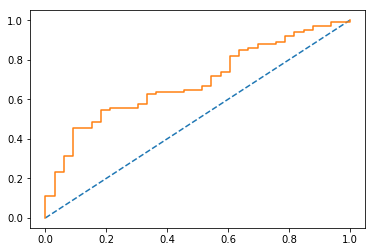

0.6874808692990511


In [78]:
xgb_proba = random_search.best_estimator_.predict_proba(X2_test)

probs = xgb_proba[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y2_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# show the plot
plt.show()
auc = roc_auc_score(y2_test, probs)
print(auc)

In [80]:
parameters = {
                'booster': ['gbtree','dart'],
                'verbosity': [2],
                'learning_rate': [0.01,0.05,0.1],
                "n_estimators":[75,150,200],
                'gamma': [0,1,5],
                'max_depth': [3,4,5],
                'scale_pos_weight': [1],
                'subsample': [0.3, 0.4],
                'colsample_bytree': [0.2,0.3,0.5],
                'lambda': [0,0.33,0.66,1]
            }

eval_set = [(X2_train, y2_train), (X2_test, y2_test)]
eval_metric = ["auc"]

xgb_test = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, eval_metric=eval_metric, eval_set=eval_set)

folds = 2
param_comb = 500

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 6)

random_search = RandomizedSearchCV(xgb_test, param_distributions=parameters, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=-4, cv=skf.split(X2_train,y2_train), verbose=3, random_state=6 )

random_search.fit(X2_train, y2_train)


Fitting 2 folds for each of 500 candidates, totalling 1000 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=-4)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-4)]: Done 178 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-4)]: Done 498 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-4)]: Done 946 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-4)]: Done 975 out of 1000 | elapsed:   12.4s remaining:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   13.0s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fc3d8e89888>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric=['auc'],
                                           eval_set=[(     industry_bin__Other  short_sentences_iqr_standardized  \
303                    0                          0.320988   
75                     0                          0.308642   
267                    0                          0.460905   
491                    0                          0.399177   
101                    0                          0.386831   
..                   ...                               ....
                   param_distributions={'booster': ['gbtree', 'dart'],

In [81]:
print(classification_report(y_pred=random_search.best_estimator_.predict(X2_test), y_true=y2_test))

              precision    recall  f1-score   support

           0       0.40      0.36      0.38        33
           1       0.79      0.82      0.81        99

    accuracy                           0.70       132
   macro avg       0.60      0.59      0.59       132
weighted avg       0.70      0.70      0.70       132



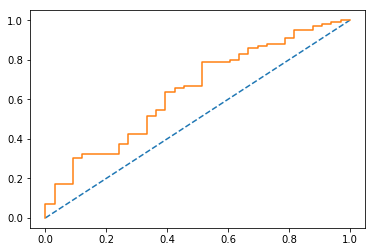

0.6406489133761861


In [82]:
xgb_proba = random_search.best_estimator_.predict_proba(X2_test)

probs = xgb_proba[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y2_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# show the plot
plt.show()
auc = roc_auc_score(y2_test, probs)
print(auc)

In [155]:
# Splitting data into testing and training
X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)

# Begin oversampling
oversample = pd.concat([X2_train,y2_train],axis=1)
max_size = oversample['Y2'].value_counts().max()
lst = [oversample]
for class_index, group in oversample.groupby('Y2'):
    lst.append(group.sample(max_size-len(group), replace=True))
X2_train = pd.concat(lst)
y2_train=pd.DataFrame.copy(X2_train['Y2'])
del X2_train['Y2']

In [174]:
parameters = {
                'booster': ['gbtree','dart'],
                'verbosity': [2],
                'learning_rate': [0.01,0.05,0.1],
#                 "n_estimators":[75,150,200],
                'gamma': [0,1,5],
                'max_depth': [3,4,5],
                'scale_pos_weight': [1],
                'subsample': [0.6, 0.7],
                'colsample_bytree': [0.2,0.3,0.5],
                'lambda': [0,0.33,0.66,1]
            }

eval_set = [(X2_train, y2_train), (X2_test, y2_test)]
eval_metric = ["auc"]

xgb_test = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, eval_metric=eval_metric, eval_set=eval_set)

folds = 2
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 6)

random_search = RandomizedSearchCV(xgb_test, param_distributions=parameters, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=-4, cv=skf.split(X2_train,y2_train), verbose=3, random_state=6 )

random_search.fit(X2_train, y2_train)


Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=-4)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-4)]: Done 200 out of 200 | elapsed:    2.0s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f4042368c50>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric=['auc'],
                                           eval_set=[(      C2  C3_imputed_normalized  C5_prime_iqr_standardized_normalized  \
303  1.0               0.066772                             -0.702535   
75   1.0               0.069067                              1.476454   
267  1.0               0.10163...
                   iid='deprecated', n_iter=100, n_jobs=-4,
                   param_distributions={'booster': ['gbtree', 'dart'],
                                        'colsample_bytree': [0.2, 0.3, 0.5],
                                        '

In [175]:
print(classification_report(y_pred=random_search.best_estimator_.predict(X2_test), y_true=y2_test))

              precision    recall  f1-score   support

           0       0.52      0.36      0.43        33
           1       0.81      0.89      0.85        99

    accuracy                           0.76       132
   macro avg       0.66      0.63      0.64       132
weighted avg       0.74      0.76      0.74       132



In [178]:
precision_recall_fscore_support(y2_test, random_search.best_estimator_.predict(X2_test), average='weighted')[2]

0.7417582417582418

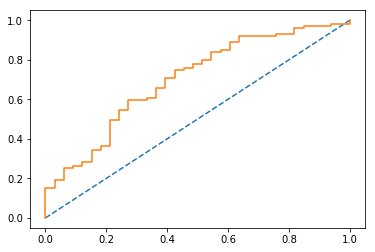

0.6991123354759717


In [176]:
xgb_proba = random_search.best_estimator_.predict_proba(X2_test)

probs = xgb_proba[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y2_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# show the plot
plt.show()
auc = roc_auc_score(y2_test, probs)
print(auc)

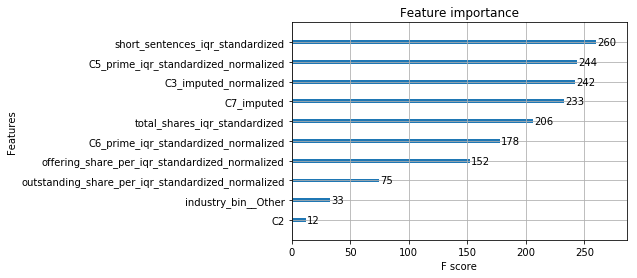

In [186]:
xgb.plot_importance(random_search.best_estimator_)


The XGBoost model predicts far better than the previous Logistic Regression. We can leverage the feature importances provided by this model for use in the Logistic Regression to see how much of an impact we can make.

In [188]:
predictors_y2 = feat_mat[['short_sentences_iqr_standardized','C5_prime_iqr_standardized_normalized',
                         'C3_imputed_normalized','C7_imputed','total_shares_iqr_standardized',
                         'C6_prime_iqr_standardized_normalized','offering_share_per_iqr_standardized_normalized',
                         'outstanding_share_per_iqr_standardized_normalized','industry_bin__Other',
                         'C2']]

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    #Model building
    clf1 = LogisticRegression()

    
    # Splitting data into testing and training
    X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)
    
    # Begin oversampling
    oversample = pd.concat([X2_train,y2_train],axis=1)
    max_size = oversample['Y2'].value_counts().max()
    lst = [oversample]
    for class_index, group in oversample.groupby('Y2'):
        lst.append(group.sample(max_size-len(group), replace=True))
    X2_train = pd.concat(lst)
    y2_train=pd.DataFrame.copy(X2_train['Y2'])
    del X2_train['Y2']
    
    # fitting model on oversampled data
    clf1.fit(X2_train, y2_train)
    
    y2_pred = clf1.predict(X2_test)
    
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)
    
    #calculate f1-score and AUC
    
    clf1_roc_auc = roc_auc_score(y2_test, y2_pred)
    
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
    auc_lst.append(clf1_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

print('Confusion Matrix for Classfier:')
print(confusion_matrix_y2)

print('Classification Report for Classfier:')
print(classification_report(y2_test, y2_pred))

imp = pd.DataFrame(zip(predictors_y2.columns, clf1.coef_[0]))
imp.columns = ['field','importance']
imp.sort_values('importance')


/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6652; AUC 0.6195 
Accuracy of classifier on test set: 0.636
10-fold cross validation average accuracy of clf1: 0.597
Confusion Matrix for Classfier:
[[19 14]
 [34 65]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.36      0.58      0.44        33
           1       0.82      0.66      0.73        99

    accuracy                           0.64       132
   macro avg       0.59      0.62      0.59       132
weighted avg       0.71      0.64      0.66       132



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


,field,importance
8,industry_bin__Other,-0.608272
4,total_shares_iqr_standardized,-0.494426
2,C3_imputed_normalized,-0.433148
0,short_sentences_iqr_standardized,-0.346653
7,outstanding_share_per_iqr_standardized_normalized,-0.081626
9,C2,0.132328
6,offering_share_per_iqr_standardized_normalized,0.342903
1,C5_prime_iqr_standardized_normalized,0.527213
5,C6_prime_iqr_standardized_normalized,0.598862
3,C7_imputed,0.671099


No real luck here, but we know that there is a reliable XGBoost model which can perform better. 